In [ ]:
import os
import glob
import datacube
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from odc.geo.geom import Geometry, box
from odc.geo.xr import rio_reproject, assign_crs
from rasterio.enums import Resampling

import sys

sys.path.insert(1, "/home/jovyan/dev/Tools/")
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb, display_map


In [ ]:
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 14.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44475,Workers: 1
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 14.25 GiB
Comm: tcp://127.0.0.1:33227,Total threads: 2
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/44453/status,Memory: 14.25 GiB
Nanny: tcp://127.0.0.1:43525,


In [ ]:
dc = datacube.Datacube(app="modis-dea-fc-comparison")


In [ ]:
tile = ["x148y166"]

proto_fc_dir = "~/gdata1/projects/fc-sub-annual/results/tiles/"
modis_dir = "~/gdata1/projects/fc-sub-annual/"
gdf_dir = "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"

output_dir = "/gdata1/projects/fc-sub-annual/results/figures/"


In [ ]:
gdf = gpd.read_file(
    "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"
)

gdf = gdf[gdf["region_code"].isin(tile)]
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)


In [ ]:
gdf["central_lon"] = gdf.geometry.centroid.x
gdf["central_lat"] = gdf.geometry.centroid.y
lon_range = (gdf["central_lon"].values[0] - 0.05, gdf["central_lon"].values[0] + 0.05)
lat_range = (gdf["central_lat"].values[0] - 0.05, gdf["central_lat"].values[0] + 0.05)

bbox = box(lon_range[0], lat_range[0], lon_range[1], lat_range[1], crs="EPSG:4326")


/tmp/ipykernel_204/2115323164.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["central_lon"] = gdf.geometry.centroid.x
/tmp/ipykernel_204/2115323164.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["central_lat"] = gdf.geometry.centroid.y


## Read in MODIS data over tile area

For now I'm only reading in the times that fall between 01-03 and 31-08 2024 as that's what I have exported as monthly medians from the other notebook.

In [ ]:
modis_file_dir = os.path.join(
    modis_dir, "FC_Monthly_Medoid.v310.MCD43A4.Australia.2024.nc"
)

modis_ds = xr.open_dataset(modis_file_dir)
modis_ds = modis_ds.sel(time=slice("2024-03-01", "2024-08-31"))

# get time slice before renaming variables
modis_ds = modis_ds.rename({"time": "month", "latitude": "y", "longitude": "x"})
modis_ds = assign_crs(modis_ds, "EPSG:4326")
modis_ds = modis_ds.rio.clip([bbox], all_touched=True, drop=True)

modis_ds


<xarray.Dataset> Size: 43kB
Dimensions:      (month: 6, y: 21, x: 21)
Coordinates:
  * month        (month) datetime64[ns] 48B 2024-03-01 2024-04-01 ... 2024-08-01
  * y            (y) float64 168B -14.84 -14.85 -14.86 ... -14.94 -14.94 -14.95
  * x            (x) float64 168B 135.0 135.1 135.1 135.1 ... 135.1 135.1 135.1
    spatial_ref  int64 8B 0
Data variables:
    phot_veg     (month, y, x) float32 11kB nan nan nan ... 22.09 20.31 21.51
    nphot_veg    (month, y, x) float32 11kB nan nan nan ... 62.56 66.28 66.55
    bare_soil    (month, y, x) float32 11kB nan nan nan ... 13.94 12.11 10.19
    tot_cov      (month, y, x) float32 11kB nan nan nan ... 84.65 86.59 88.06

## get geomedian and DEA FC

In [ ]:
geomad_ds = dc.load(
    product="ga_ls8cls9c_gm_cyear_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    x=lon_range,
    y=lat_range,
    time=("2023"),
    dask_chunks={"x": 2048, "y": 2048},
)


In [ ]:
geomad_rgb = geomad_ds[["nbart_red", "nbart_green", "nbart_blue"]].to_array().compute()


In [ ]:
monthly_fcs_fname = (
    f"{tile[0]}/monthly_fc_blended_medians_2024-03-01-2024-08-31_{tile[0]}.nc"
)
monthly_fcs = xr.open_dataset(
    os.path.expanduser(os.path.join(proto_fc_dir, monthly_fcs_fname))
)

monthly_fcs = assign_crs(monthly_fcs, "EPSG:3577")

monthly_fcs = monthly_fcs.squeeze().drop_vars("year")
monthly_fcs


<xarray.Dataset> Size: 20MB
Dimensions:      (month: 6, y: 375, x: 372)
Coordinates:
  * month        (month) datetime64[ns] 48B 1970-01-01T00:00:03 ... 1970-01-0...
  * y            (y) float64 3kB -1.578e+06 -1.578e+06 ... -1.59e+06 -1.59e+06
  * x            (x) float64 3kB 3.304e+05 3.305e+05 ... 3.415e+05 3.416e+05
    spatial_ref  int32 4B 3577
Data variables:
    BS           (y, x, month) float32 3MB ...
    PV           (y, x, month) float32 3MB ...
    NPV          (y, x, month) float32 3MB ...
    UE           (y, x, month) float32 3MB ...
    obs_count    (month, y, x) float64 7MB ...
Attributes:
    date_created:           2025-08-19T07:31:24.509436
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.8.2...
    geospatial_bounds:      POLYGON ((135.04207095841014 -14.843579429005388,...
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -14.946150583023831
    geospatial_lat_max:     -14.841114787316918
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     135.04207095841014
    geospatial_lon_max:     135.1473277538983
    geospatial_lon_units:   degrees_east

In [ ]:
modis_ds.dims


FrozenMappingWarningOnValuesAccess({'month': 6, 'y': 21, 'x': 21})

In [ ]:
monthly_fcs_resample = monthly_fcs.odc.reproject(
    how=modis_ds.odc.geobox, resampling="average"
).compute()


In [ ]:
# modis_ds = modis_ds.transpose("month", "y", "x")
# monthly_fcs = monthly_fcs.transpose("month", "y", "x")
# monthly_fcs_resample = monthly_fcs.rio.reproject_match(
#     modis_ds, resampling=Resampling.bilinear
# )


In [ ]:
for i, t in enumerate(modis_ds.month.values):
    fig = plt.figure(figsize=(16, 6))

    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.08])
    axs = {}

    axs["geomad"] = fig.add_subplot(gs[0:2, 0:2])
    axs["phot_veg"] = fig.add_subplot(gs[0, 2])
    axs["nphot_veg"] = fig.add_subplot(gs[0, 3])
    axs["bare_soil"] = fig.add_subplot(gs[0, 4])
    axs["PV"] = fig.add_subplot(gs[1, 2])
    axs["NPV"] = fig.add_subplot(gs[1, 3])
    axs["BS"] = fig.add_subplot(gs[1, 4])

    # disable axis ticks
    for ax in axs.values():
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

    # Select the first time slice and transpose to (y, x, 3) for RGB plotting
    rgb_img = geomad_rgb.isel(time=0)

    rgb_img.plot.imshow(
        ax=axs["geomad"],
        robust=True,
        add_colorbar=False,
        add_labels=False,
    )

    im = None
    for var in ["phot_veg", "nphot_veg", "bare_soil"]:
        img = (
            modis_ds[var]
            .isel(month=i)
            .plot.imshow(
                ax=axs[var],
                vmin=0,
                vmax=100,
                cmap="magma",
                add_colorbar=False,
                add_labels=False,
            )
        )
        axs[var].set_title(var.replace("_", " ").title())
        if im is None:
            im = img

    for var in ["PV", "NPV", "BS"]:
        img = (
            monthly_fcs[var]
            .isel(month=i)
            .plot.imshow(
                ax=axs[var],
                vmin=0,
                vmax=100,
                cmap="magma",
                add_colorbar=False,
                add_labels=False,
            )
        )

        axs[var].set_title(var.replace("_", " ").title())
        if im is None:
            im = img

    cax = fig.add_subplot(gs[:, 5])
    plt.colorbar(im, cax=cax)

    fname = f"{tile[0]}/modis-dea-fc-comparison-{pd.to_datetime(t).strftime('%Y-%m')}_{tile[0]}.png"
    fig.savefig(os.path.join(output_dir, fname), dpi=200, bbox_inches="tight")
    plt.close()


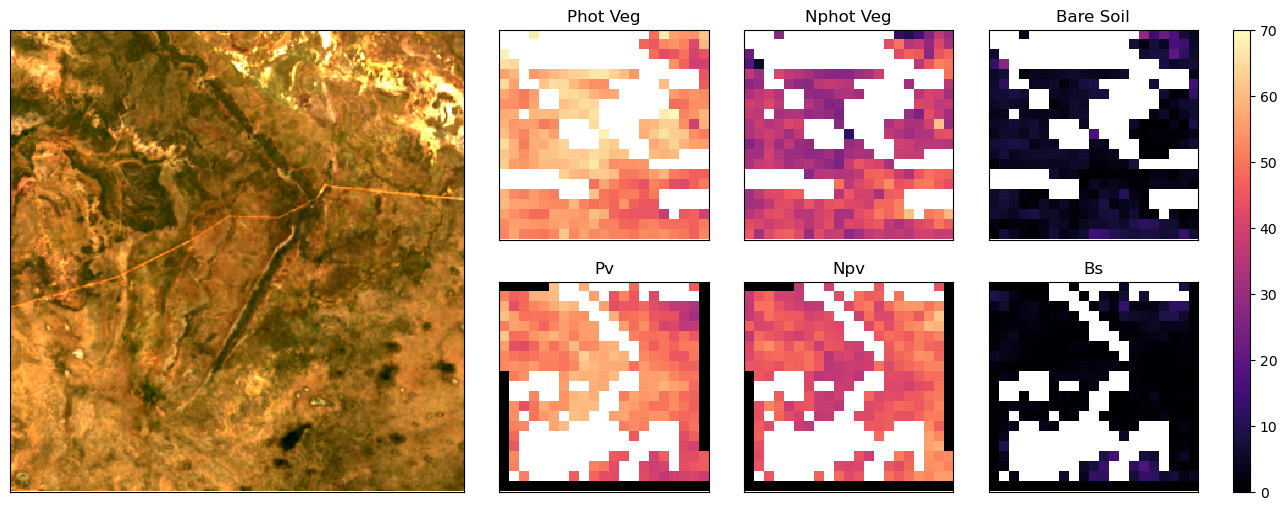

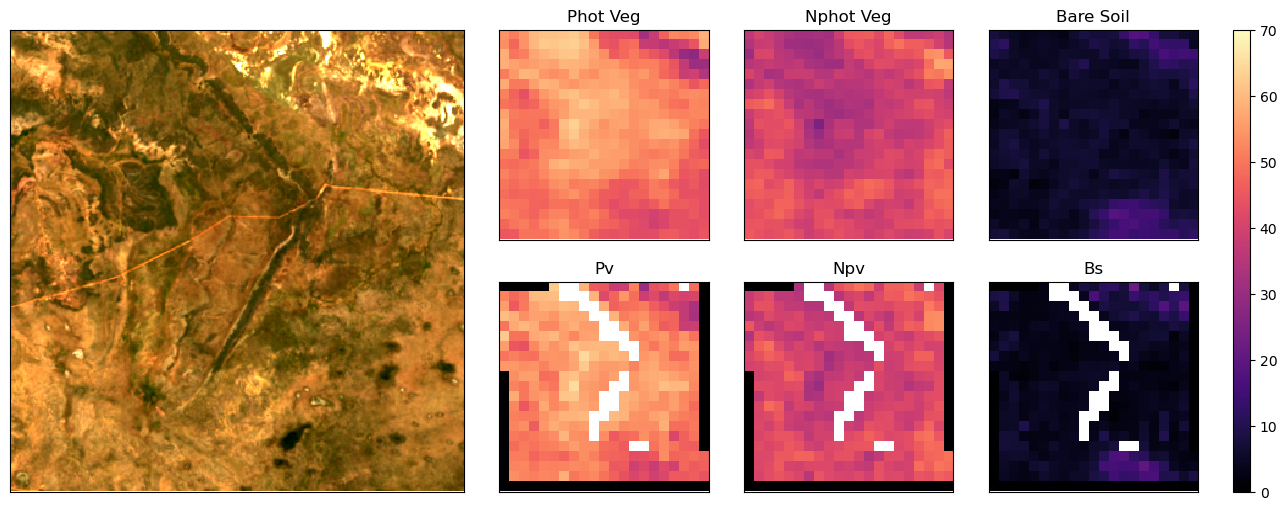

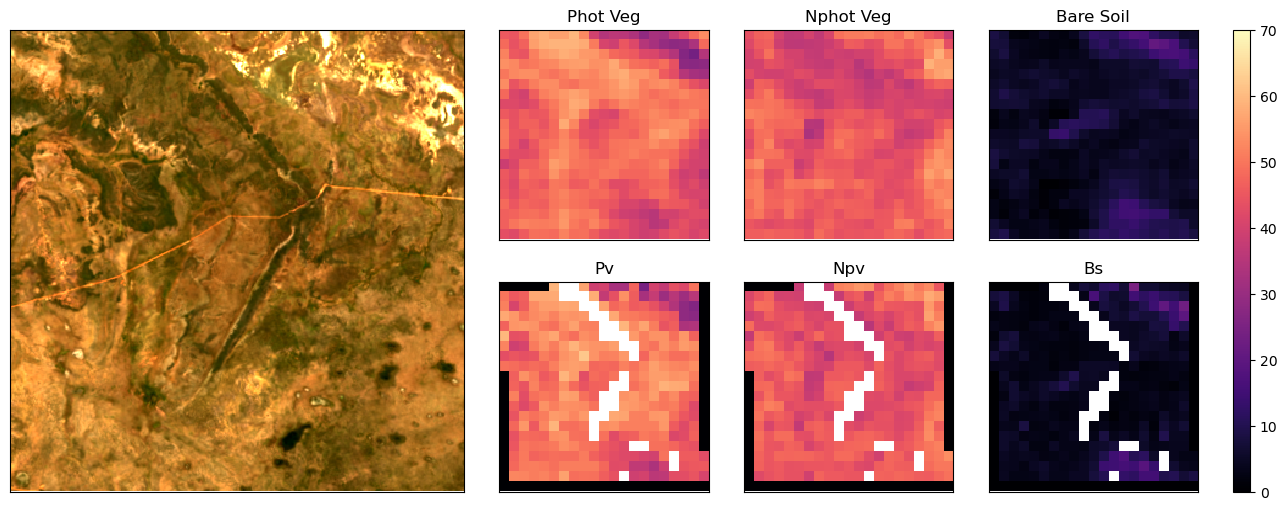

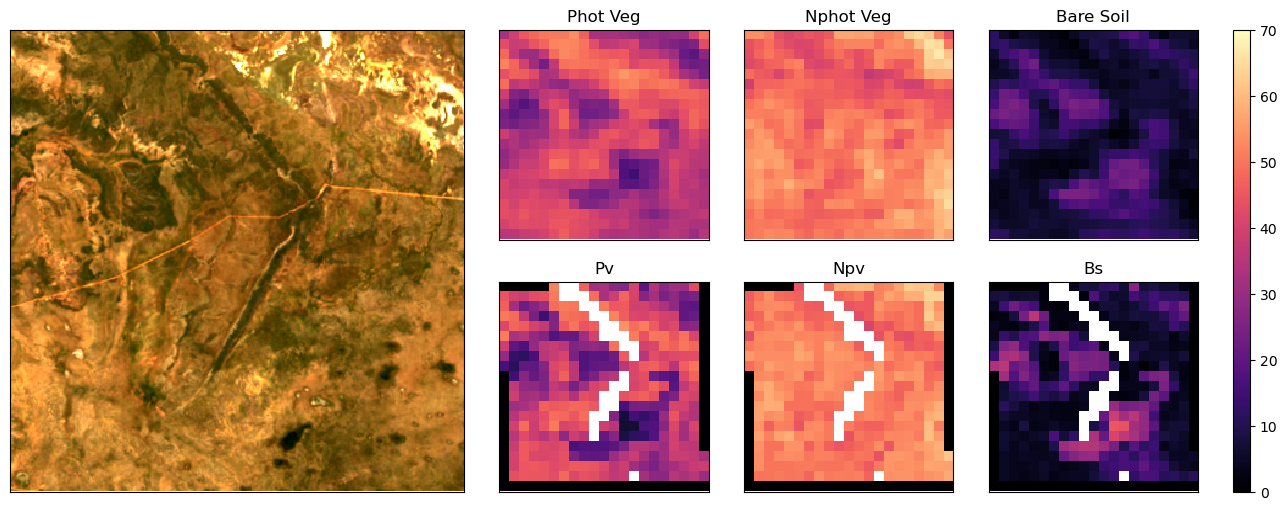

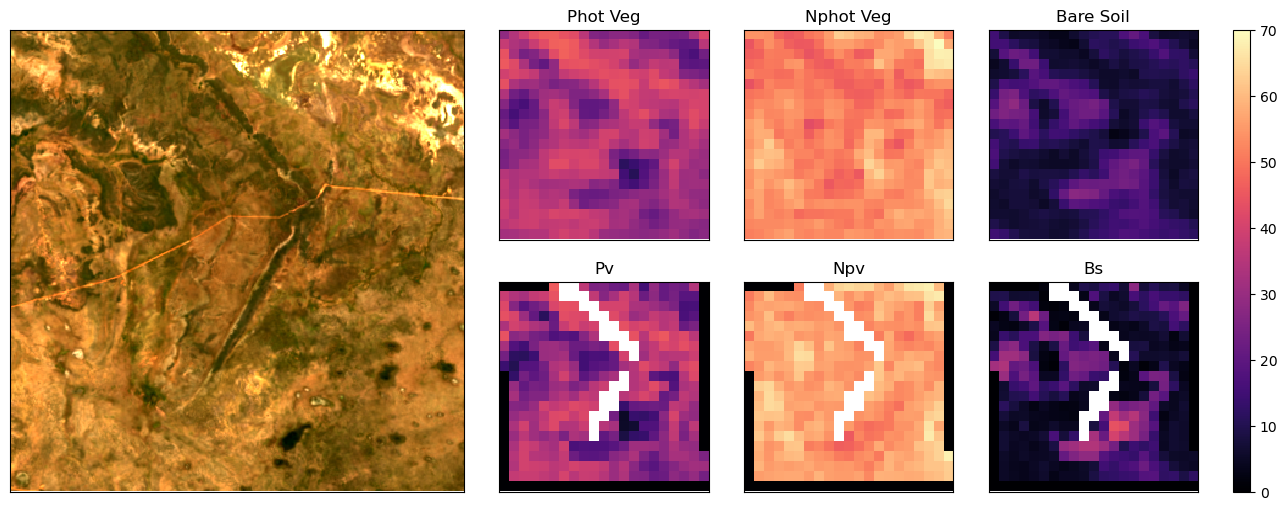

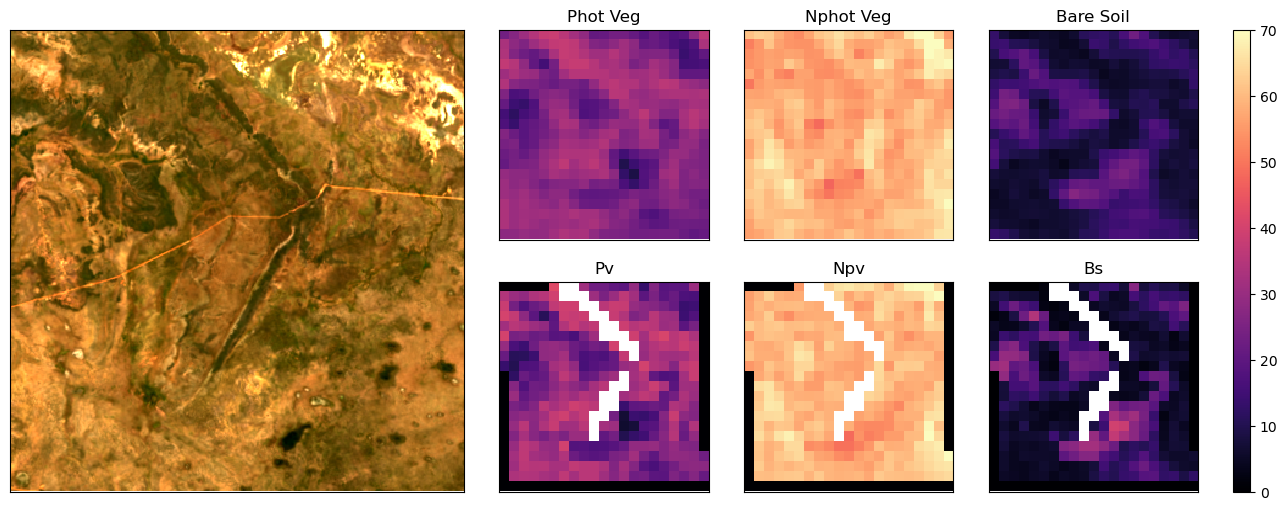

In [ ]:
for i, t in enumerate(modis_ds.month.values):
    fig = plt.figure(figsize=(16, 6))

    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.08])
    axs = {}

    axs["geomad"] = fig.add_subplot(gs[0:2, 0:2])
    axs["phot_veg"] = fig.add_subplot(gs[0, 2])
    axs["nphot_veg"] = fig.add_subplot(gs[0, 3])
    axs["bare_soil"] = fig.add_subplot(gs[0, 4])
    axs["PV"] = fig.add_subplot(gs[1, 2])
    axs["NPV"] = fig.add_subplot(gs[1, 3])
    axs["BS"] = fig.add_subplot(gs[1, 4])

    # disable axis ticks
    for ax in axs.values():
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

    # Select the first time slice and transpose to (y, x, 3) for RGB plotting
    rgb_img = geomad_rgb.isel(time=0)

    rgb_img.plot.imshow(
        ax=axs["geomad"],
        robust=True,
        add_colorbar=False,
        add_labels=False,
    )

    im = None
    for var in ["phot_veg", "nphot_veg", "bare_soil"]:
        img = (
            modis_ds[var]
            .isel(month=i)
            .plot.imshow(
                ax=axs[var],
                vmin=0,
                vmax=70,
                cmap="magma",
                add_colorbar=False,
                add_labels=False,
            )
        )
        axs[var].set_title(var.replace("_", " ").title())
        if im is None:
            im = img

    for var in ["PV", "NPV", "BS"]:
        img = (
            monthly_fcs_resample[var]
            .isel(month=i)
            .plot.imshow(
                ax=axs[var],
                vmin=0,
                vmax=70,
                cmap="magma",
                add_colorbar=False,
                add_labels=False,
            )
        )

        axs[var].set_title(var.replace("_", " ").title())
        if im is None:
            im = img

    cax = fig.add_subplot(gs[:, 5])
    plt.colorbar(im, cax=cax)

    fname = f"{tile[0]}/modis-dea-fc-comparison-resampled-{pd.to_datetime(t).strftime('%Y-%m')}_{tile[0]}.png"
    fig.savefig(os.path.join(output_dir, fname), dpi=200, bbox_inches="tight")
    # plt.close()
